In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

from torchsummary import summary

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

     
def show_anns(anns):
    if len(anns) == 0:
        return
    
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    if type(anns) == np.ndarray:
        ax = plt.gca()
        ax.set_autoscale_on(False)

        img = np.ones((anns.shape[1], anns.shape[2], 4))
        img[:,:,3] = 0
        for ann in tqdm(anns):
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[ann] = color_mask
        ax.imshow(img)
    else:
        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

        img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
        img[:,:,3] = 0
        for ann in tqdm(sorted_anns):
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask
        ax.imshow(img)

### SAM

In [99]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

image = cv2.imread('cat.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

input_point = np.array([[2000, 1500]])
input_label = np.array([1])

#### 1 point prompt

In [100]:
for i in tqdm(range(1)):
    predictor.set_image(image)

    sam_mask, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False
    )

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.89s/it]


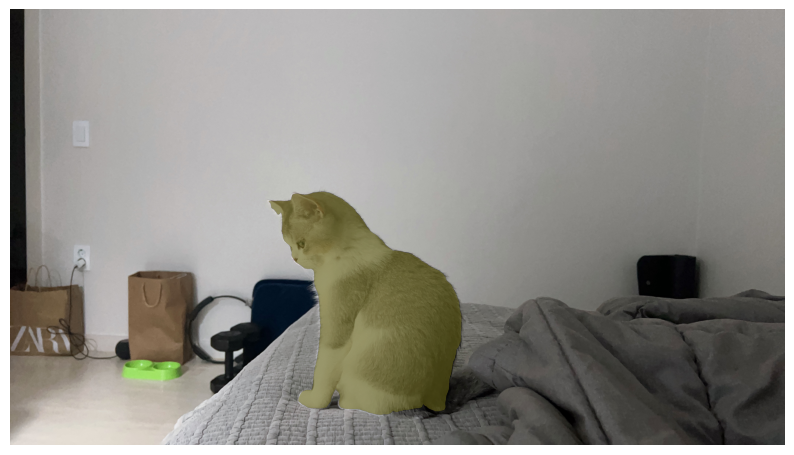

In [101]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(sam_mask, plt.gca(), random_color=True)
plt.axis('off')
plt.show() 

#### everything

In [4]:
masks = mask_generator.generate(image)

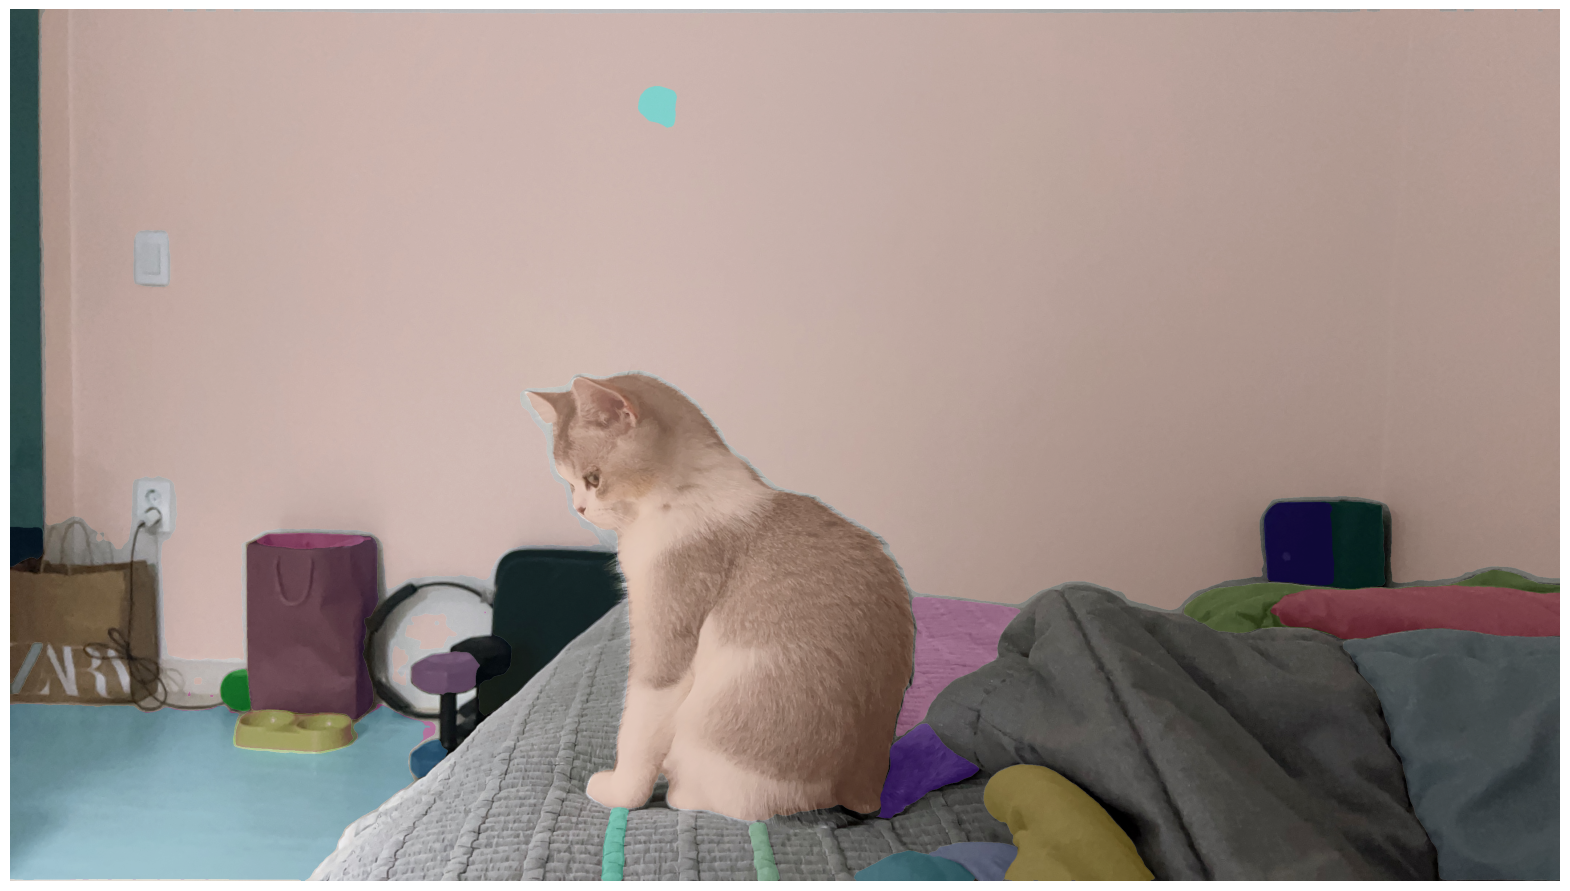

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

### FastSAM

In [116]:
from FastSAM.fastsam import FastSAM, FastSAMPrompt

# model = FastSAM('./FastSAM/weights/FastSAM-s.pt')
model = FastSAM('./FastSAM/weights/FastSAM-x.pt')


IMAGE_PATH = "cat.jpeg"
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
DEVICE = 'cpu'

#### 1 point prompt

In [108]:
for i in tqdm(range(1)):
    everything_results = model(IMAGE_PATH, device=DEVICE, verbose=False, retina_masks=True, imgsz=1024, conf=0.4, iou=0.8,)
    prompt_process = FastSAMPrompt(IMAGE_PATH, everything_results, device=DEVICE)

    # everything prompt
    fastsam_mask = prompt_process.point_prompt(points=[[2000, 1500]], pointlabel=[1])

# ann = prompt_process.box_prompt(bbox=[1500, 740, 3600, 1200])

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]


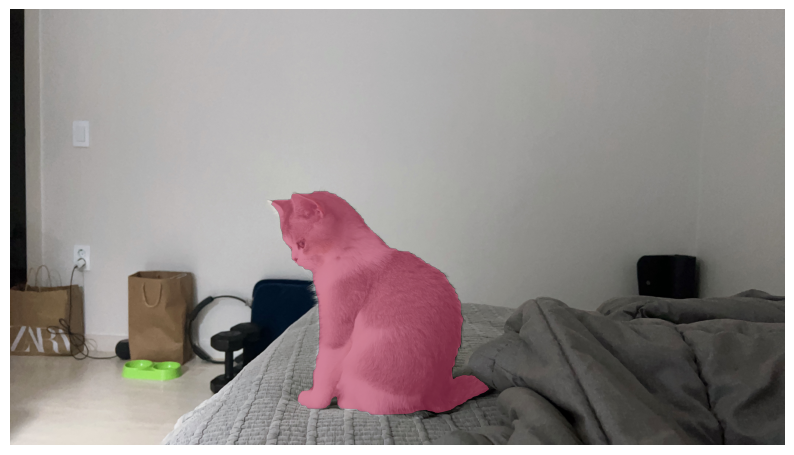

In [109]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(fastsam_mask, plt.gca(), random_color=True)
plt.axis('off')
plt.show() 

#### everything

In [117]:
everything_results = model(IMAGE_PATH, device=DEVICE, verbose=False, retina_masks=True, imgsz=1024, conf=0.4, iou=0.8,)
prompt_process = FastSAMPrompt(IMAGE_PATH, everything_results, device=DEVICE)

ann = prompt_process.everything_prompt()

100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 41.07it/s]


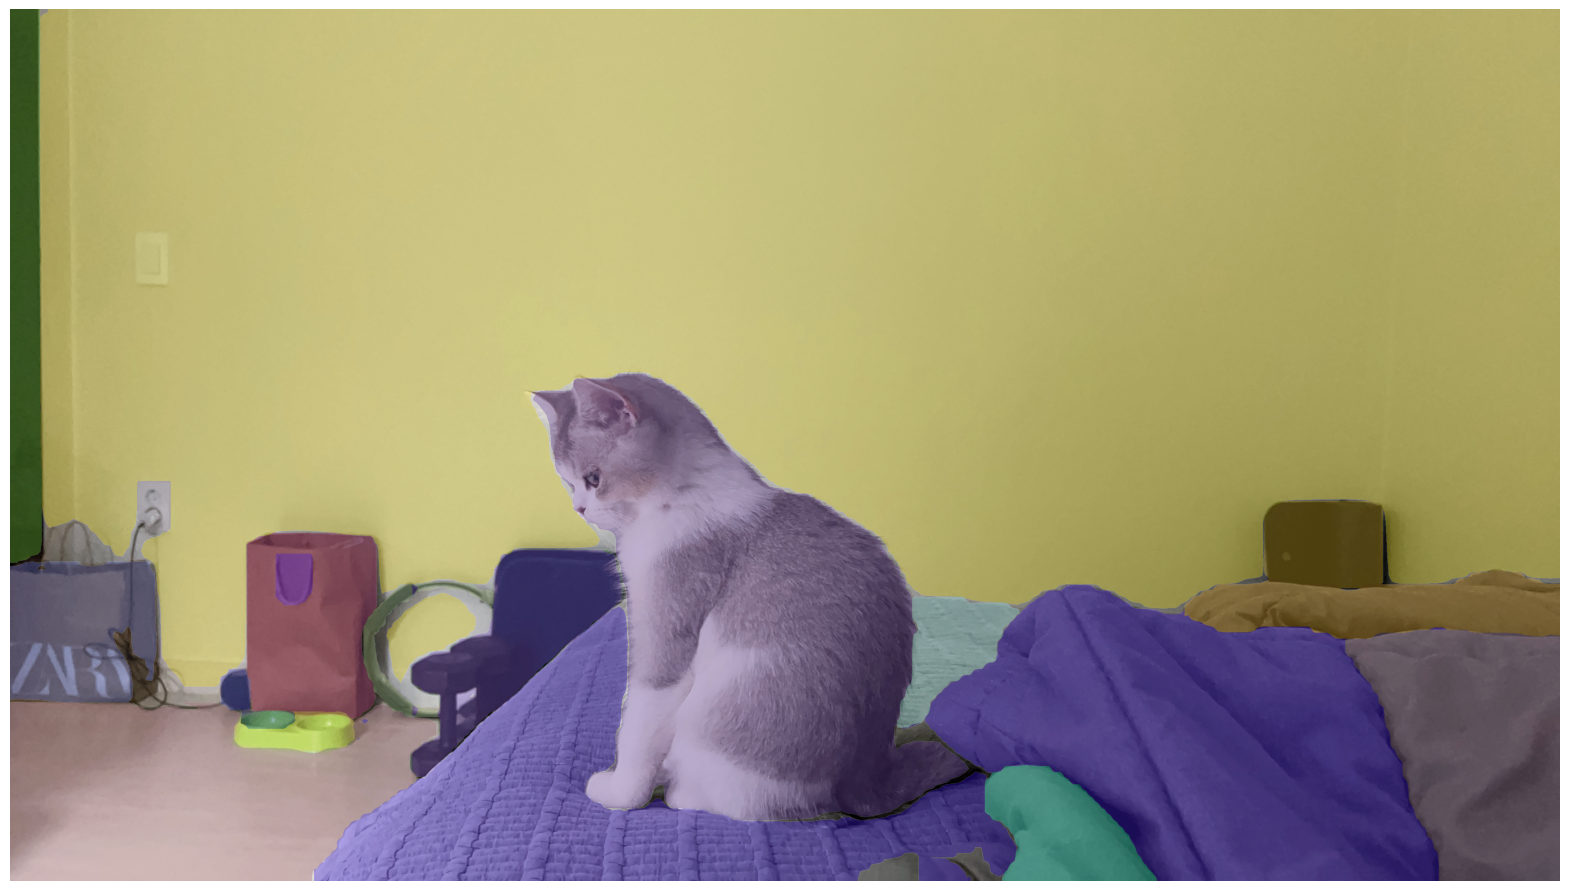

In [118]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(np.array(ann, dtype=bool))

plt.axis('off')
plt.show() 

### MobileSAM

In [3]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_t"
sam_checkpoint = "./MobileSAM/weights/mobile_sam.pt"
device = "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)

predictor = SamPredictor(mobile_sam)
mask_generator = SamAutomaticMaskGenerator(mobile_sam)

image = cv2.imread('cat.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

input_point = np.array([[2000, 1500]])
input_label = np.array([1])

#### 1 point prompt

In [111]:
for i in tqdm(range(1)):

    predictor.set_image(image)

    mobilesam_mask, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )

100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.27s/it]


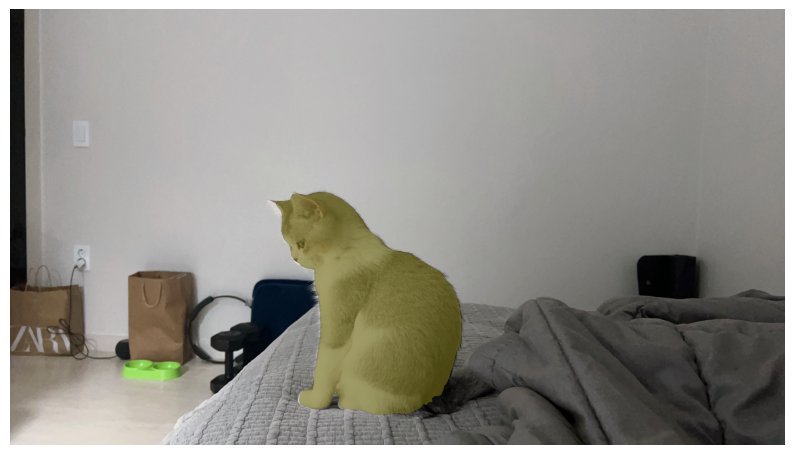

In [112]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(mobilesam_mask, plt.gca(), random_color=True)
plt.axis('off')
plt.show() 

#### everything

In [4]:
masks = mask_generator.generate(image)

100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 34.20it/s]


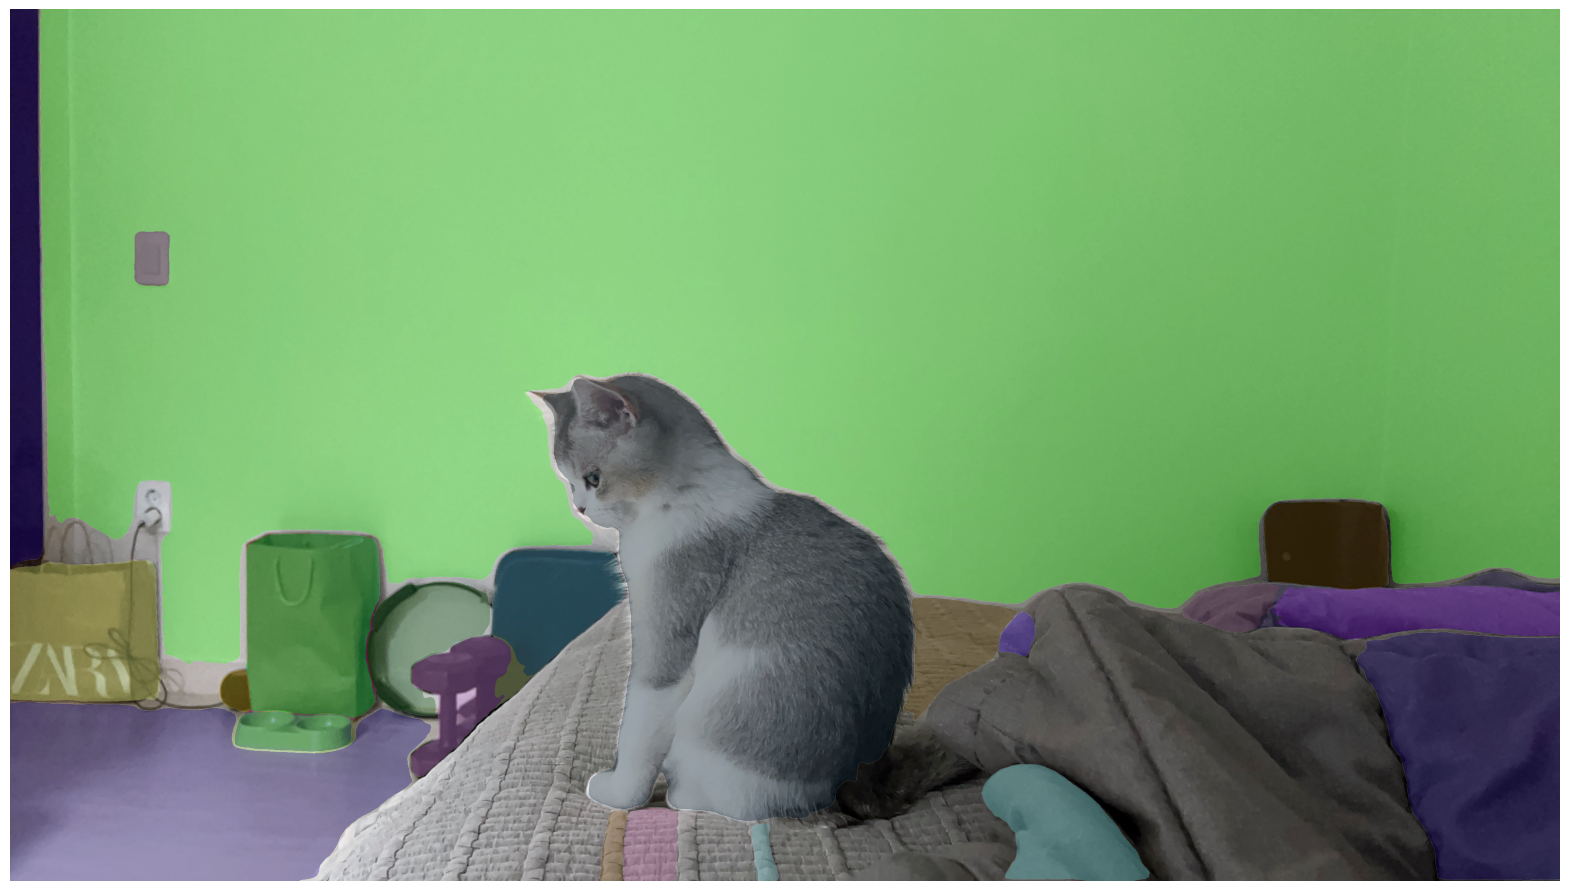

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)

plt.axis('off')
plt.show() 